## 1. Plotting Actions

### The exercise
1. Think of a player who you enjoyed watching at the recent mens Euros 2024 or women's World Cup 2023.
2. What actions did they perform that were important and why?
3. Download data from Statsbomb for the tournamentsLinks to an external site.. Plot the actions and describe how the data supports or contradicts your own analysis.
4. Compare the players (using statistical methods) to other players in the tournament.
5. Write a short text using at most two figures that illustrate your point.


## Import Packages

In [4]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd
import numpy as np
import math
import seaborn as sns
from scipy.stats import ttest_ind

## Open and Import EURO 2024 Data 

In [5]:
parser = Sbopen()
df_match = parser.match(competition_id=55, season_id=282)

In [6]:
df_all_matches = pd.DataFrame()
for match in list(df_match['match_id']):
    df_event = pd.DataFrame(parser.event(match)[0])
    df_all_matches = pd.concat([df_all_matches, df_event], ignore_index=True)
len(df_all_matches)

187858

In [55]:
df_all_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187858 entries, 0 to 187857
Data columns (total 87 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              187858 non-null  object 
 1   index                           187858 non-null  int64  
 2   period                          187858 non-null  int64  
 3   timestamp                       187858 non-null  object 
 4   minute                          187858 non-null  int64  
 5   second                          187858 non-null  int64  
 6   possession                      187858 non-null  int64  
 7   duration                        136240 non-null  float64
 8   match_id                        187858 non-null  int64  
 9   type_id                         187858 non-null  int64  
 10  type_name                       187858 non-null  object 
 11  possession_team_id              187858 non-null  int64  
 12  possession_team_

## Key Functions: Calculate distance to goal + plot player passes

In [44]:
def check_action_leads_to_shot(row, df, time_delta=15):
    """
    Check if the action from the specified row leads to a shot from the same team within a specified time delta in the same match.
    
    Args:
    - row: The current row being processed.
    - df: The DataFrame containing all actions and shots.
    - time_delta: The time window to check for shots after the action (in seconds).
    
    Returns:
    - True if the action leads to a shot from the same team within the time delta in the same match, otherwise False.
    """
    action_minute = row['minute']
    action_second = row['second']
    action_time_in_seconds = action_minute * 60 + action_second
    action_team = row['team_name']
    action_match_id = row['match_id']
    
    # Filter the DataFrame for shots by the same team in the same match after the action time
    potential_shots = df[(df['team_name'] == action_team) &
                         (df['type_name'] == 'Shot') &
                         (df['match_id'] == action_match_id)]
    
    # Convert the shot times to seconds
    potential_shots['time_in_seconds'] = potential_shots['minute'] * 60 + potential_shots['second']
    
    # Check if there are any shots within the time delta
    is_leading = potential_shots['time_in_seconds'].apply(
        lambda x: action_time_in_seconds < x <= action_time_in_seconds + time_delta
    ).any()
    
    return is_leading

In [7]:

# Define the distance calculation function
def calculate_distance(row):
    x = row['x']
    y = row['y']
    
    # Calculate x distance (assuming goal is at (120, 40))
    x_dist = 120 - x

    # Calculate y distance, keeping the range between [36, 44]
    if y < 36:
        y_dist = 36 - y
    elif y > 44:
        y_dist = y - 44
    else:
    #if a player is aligned with the goal at the moment of action then we set y=0
        y_dist = 0

    # Return the Euclidean distance
    return math.sqrt(x_dist**2 + y_dist**2)

In [8]:
def plot_player_passes(df, player_name, title):
    # Filter for passes by the player
    mask_passes = (df.type_name == 'Pass') & (df.player_name == player_name)
    mask_carry = (df.type_name == 'Carry') & (df.player_name == player_name)
    
    # Separate passes into completed and incomplete
    df_completed_passes = df.loc[mask_passes & (df.outcome_name != 'Incomplete'), ['x', 'y', 'end_x', 'end_y']]
    df_incomplete_passes = df.loc[mask_passes & (df.outcome_name == 'Incomplete'), ['x', 'y', 'end_x', 'end_y']]

    df_carries = df.loc[mask_carry, ['x', 'y', 'end_x', 'end_y']]

    # Create the pitch
    pitch = Pitch(pitch_type='statsbomb', pitch_color='grass', line_color='white')
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)
    
    # Plot completed passes (blue)
    pitch.arrows(df_completed_passes.x, df_completed_passes.y,
                 df_completed_passes.end_x, df_completed_passes.end_y, 
                 color="blue", ax=ax['pitch'], label='Completed Passes')
    pitch.scatter(df_completed_passes.x, df_completed_passes.y, 
                  alpha=0.2, s=500, color="blue", ax=ax['pitch'])

    # Plot incomplete passes (red)
    pitch.arrows(df_incomplete_passes.x, df_incomplete_passes.y,
                 df_incomplete_passes.end_x, df_incomplete_passes.end_y, 
                 color="red", ax=ax['pitch'], label='Incomplete Passes')
    pitch.scatter(df_incomplete_passes.x, df_incomplete_passes.y, 
                  alpha=0.2, s=500, color="red", ax=ax['pitch'])

    # Plot Carries (yellow)
    #pitch.arrows(df_carries.x, df_carries.y,
    #             df_carries.end_x, df_carries.end_y, 
    #             color="yellow", ax=ax['pitch'], label='Carries')
    #pitch.scatter(df_carries.x, df_carries.y, 
    #              alpha=0.2, s=500, color="yellow", ax=ax['pitch'])

    # Add the legend
    ax['pitch'].legend(loc='upper right', fontsize=15)

    # Add the title and show the plot
    fig.suptitle(title, fontsize=30) 
    plt.show()

## Figure 1: Mainoo passes at Euro 2024

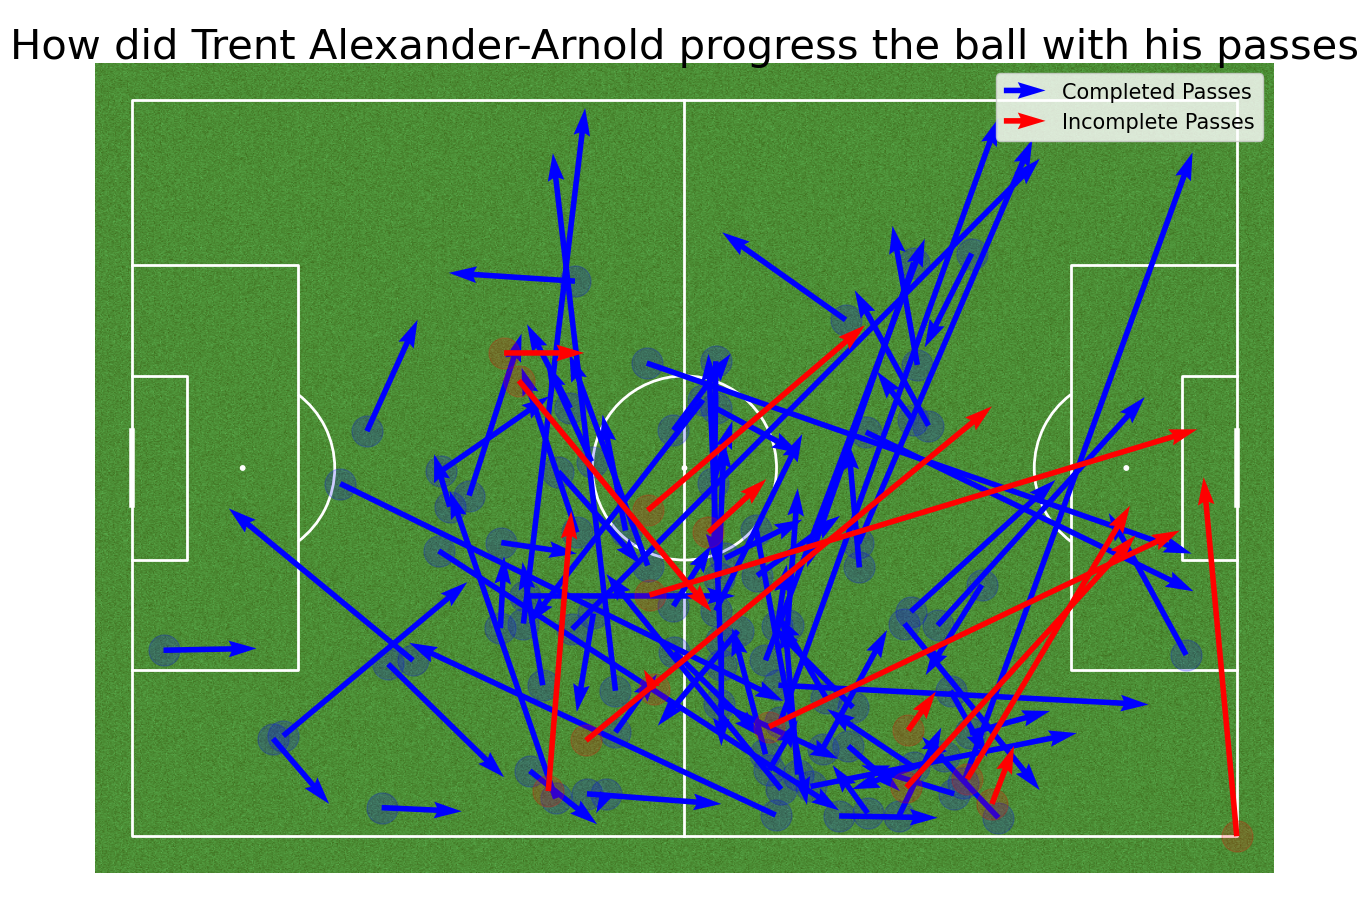

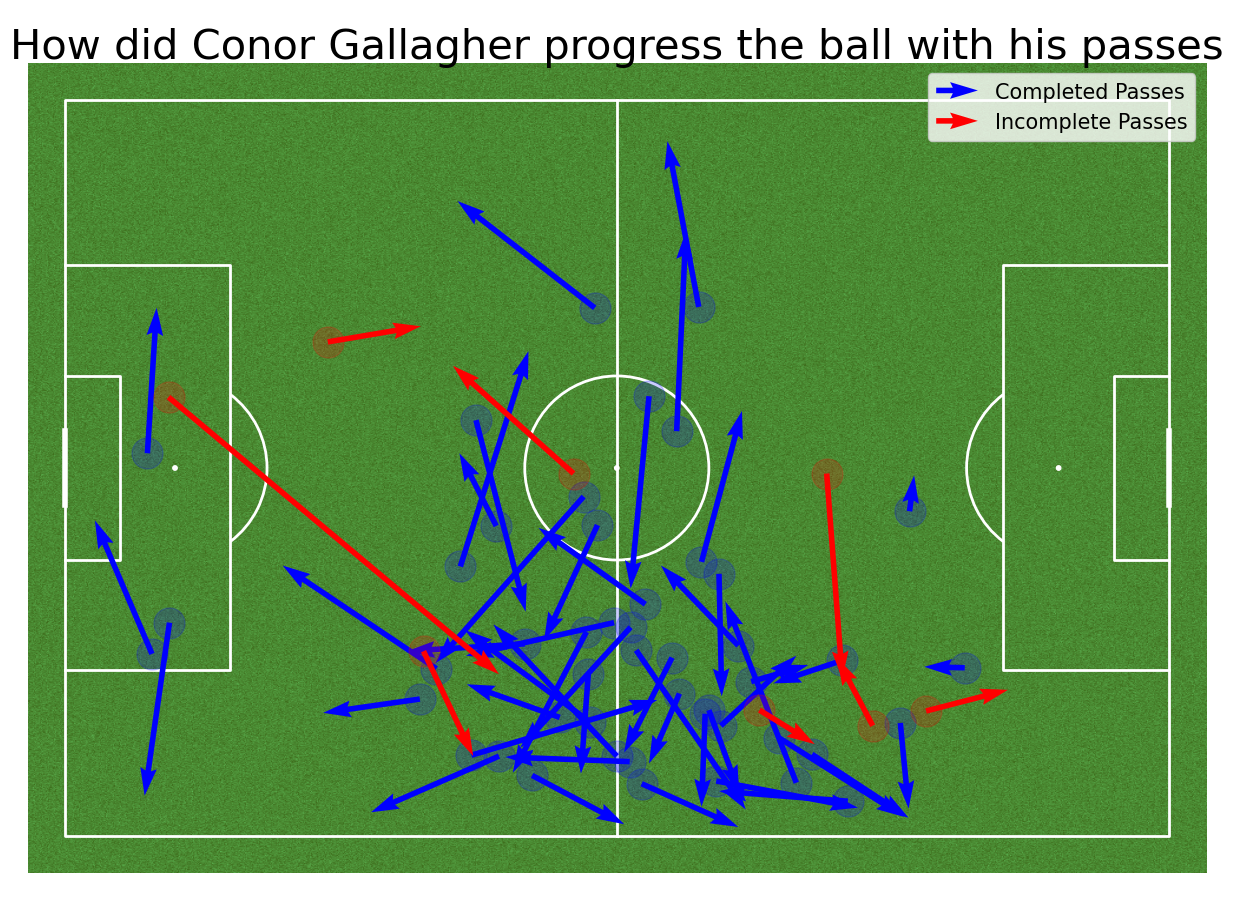

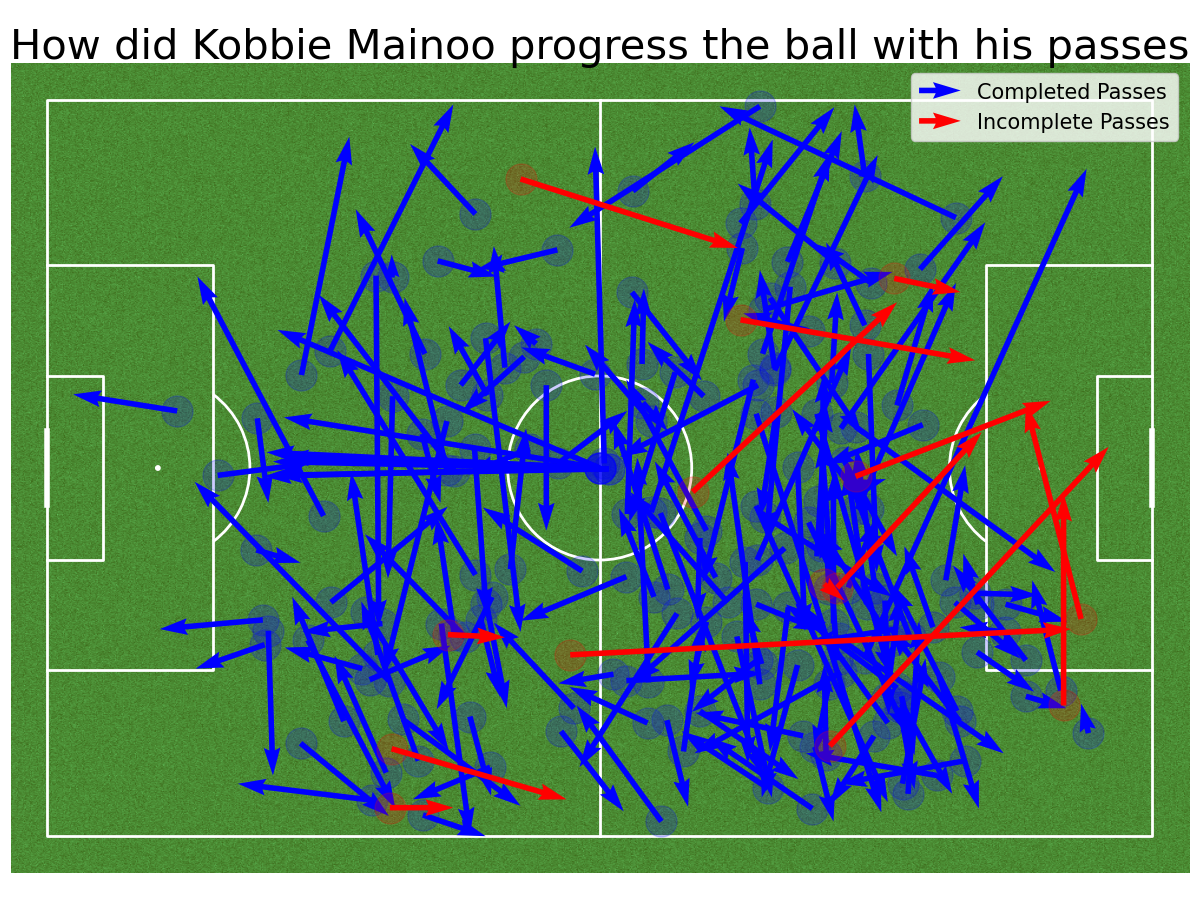

In [9]:
player_names = ['Trent Alexander-Arnold', 'Conor Gallagher', 'Kobbie Mainoo']

for player in player_names:
    plot_player_passes(df_all_matches, player, f'How did {player} progress the ball with his passes')

In [ ]:
df_all_matches['action_leads_to_shot']

## Figure 2: Pressures + Recoveries per 90 VS. Avg distance from opposition goal to complete these actions

#### 1st: Find avg distance to opposition goal per player_name

In [58]:
# Step 1: Filter the data for 'Ball Recovery' or 'Pressure' events and position_name containing 'midfield'
filtered_df = df_all_matches[
    (df_all_matches['type_name'].isin(['Ball Recovery', 'Pressure'])) &
    (
        df_all_matches['position_name'].str.contains('midfield', case=False) |
        (df_all_matches['player_name'] == 'Trent Alexander-Arnold')
    )
]

#filtered_df = filtered_df[filtered_df['match_id'] == 3943043]
filtered_df['action_leads_to_shot'] = filtered_df.apply(lambda row: check_action_leads_to_shot(row, df_all_matches), axis=1)

# Step 2: Calculate the distance for each event
filtered_df['distance_from_opposition_goal'] = filtered_df.apply(calculate_distance, axis=1)

# Step 3: Group by player and calculate the average distance
average_distance_per_player = filtered_df.groupby('player_name')['distance_from_opposition_goal'].mean().reset_index()

# Rename the column for clarity
average_distance_per_player.columns = ['player_name', 'average_distance_to_oppositions_goal']

average_distance_per_player.sort_values(by='average_distance_to_oppositions_goal', ascending=True).head()

/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_21056/1746635260.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['action_leads_to_shot'] = filtered_df.apply(lambda row: check_action_leads_to_shot(row, df_all_matches), axis=1)
/var/folders/ch/rtlgfpts12v22kcr_b8ncvqr0000gn/T/ipykernel_21056/1746635260.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['distance_from_opposition_goal'] = filtered_df.apply(calculate_distance, axis=1)


player_name  average_distance_to_oppositions_goal
39        Denis Alibec                             14.700000
161  Randal Kolo Muani                             23.923420
30   Cody Mathès Gakpo                             25.450344
108         Luka Jović                             25.700000
197    Xherdan Shaqiri                             26.927690

#### Create DF for total minutes played per player across the tournament

In [47]:
player_minutes_played_data = {
    'player_name': ['Trent Alexander-Arnold', 'Conor Gallagher', 'Kobbie Mainoo', 'Adrien Rabiot', 'Fabián Ruiz Peña', 'Vitor Machado Ferreira', 'Konrad Laimer'],
    'minutes_played': [134, 120, 368, 371, 540, 358, 270]
}

df_minutes_played = pd.DataFrame(player_minutes_played_data)

In [35]:
player_minutes_played_data = {
    'player_name': ['Kobbie Mainoo','Fabián Ruiz Peña'],
    'minutes_played': [70, 90]
}

df_minutes_played = pd.DataFrame(player_minutes_played_data)

#### Count number of Pressures and Ball Recoveries per Player, join to minutes played

In [59]:

event_counts = filtered_df.groupby(['player_name', 'type_name']).size().unstack(fill_value=0)


event_counts = event_counts.merge(df_minutes_played[['player_name', 'minutes_played']].drop_duplicates(), on='player_name', how='inner')
print(event_counts)

event_counts['pressures_recoveries'] = event_counts['Pressure'] + event_counts['Ball Recovery']
event_counts['pressures_recoveries_per_90'] = (event_counts['pressures_recoveries'] / event_counts['minutes_played']) * 90

# Step 5: Display the results
event_counts[['player_name', 'pressures_recoveries', 'minutes_played', 'pressures_recoveries_per_90']]

              player_name  Ball Recovery  Pressure  minutes_played
0           Adrien Rabiot             19        48             371
1         Conor Gallagher              3        35             120
2        Fabián Ruiz Peña             39        84             540
3           Kobbie Mainoo             16        47             368
4           Konrad Laimer             12        53             270
5  Trent Alexander-Arnold              3        14             134
6  Vitor Machado Ferreira             32        42             358


player_name  pressures_recoveries  minutes_played  \
0           Adrien Rabiot                    67             371   
1         Conor Gallagher                    38             120   
2        Fabián Ruiz Peña                   123             540   
3           Kobbie Mainoo                    63             368   
4           Konrad Laimer                    65             270   
5  Trent Alexander-Arnold                    17             134   
6  Vitor Machado Ferreira                    74             358   

   pressures_recoveries_per_90  
0                    16.253369  
1                    28.500000  
2                    20.500000  
3                    15.407609  
4                    21.666667  
5                    11.417910  
6                    18.603352

#### Join to avg distance to oppositions goal per player

In [73]:
event_counts_joined = event_counts.merge(average_distance_per_player, on='player_name', how='inner')
event_counts_joined['ball_recovery_pressure_ratio'] = event_counts_joined['Ball Recovery']/event_counts_joined['pressures_recoveries']
event_counts_joined

player_name  Ball Recovery  Pressure  minutes_played  \
0           Adrien Rabiot             19        48             371   
1         Conor Gallagher              3        35             120   
2        Fabián Ruiz Peña             39        84             540   
3           Kobbie Mainoo             16        47             368   
4           Konrad Laimer             12        53             270   
5  Trent Alexander-Arnold              3        14             134   
6  Vitor Machado Ferreira             32        42             358   

   pressures_recoveries  pressures_recoveries_per_90  \
0                    67                    16.253369   
1                    38                    28.500000   
2                   123                    20.500000   
3                    63                    15.407609   
4                    65                    21.666667   
5                    17                    11.417910   
6                    74                    18.603352   

   average_distance_to_oppositions_goal  ball_recovery_pressure_ratio  
0                             67.566833                      0.283582  
1                             69.465276                      0.078947  
2                             61.379541                      0.317073  
3                             57.671766                      0.253968  
4                             65.275132                      0.184615  
5                             82.481780                      0.176471  
6                             62.221252                      0.432432

In [72]:
# Group by player_name and calculate the sum and count of actions leading to a shot
dangerous_actions_grouped = filtered_df.groupby('player_name').agg(
    total_actions=('action_leads_to_shot', 'size'),
    actions_leading_to_shot=('action_leads_to_shot', 'sum')
)

# Calculate the proportion
dangerous_actions_grouped['proportion_leading_to_shot'] = grouped['actions_leading_to_shot'] / grouped['total_actions']

dangerous_actions_grouped = dangerous_actions_grouped.sort_values(by='proportion_leading_to_shot', ascending=False)

dangerous_actions_grouped = dangerous_actions_grouped[['proportion_leading_to_shot']]
dangerous_actions_grouped
#sorted_grouped[['total_actions', 'actions_leading_to_shot', 'proportion_leading_to_shot']].head(50)


proportion_leading_to_shot
player_name                                   
Arbër Hoxha                           1.000000
Jamal Musiala                         0.333333
Mattia Zaccagni                       0.250000
Matheus Luiz Nunes                    0.250000
Memphis Depay                         0.200000
...                                        ...
John McGinn                           0.000000
Jeremy Doku                           0.000000
Jeremie Frimpong                      0.000000
Jarrod Bowen                          0.000000
Žan Celar                             0.000000

[210 rows x 1 columns]

In [74]:
event_counts_joined = event_counts_joined.merge(dangerous_actions_grouped, on='player_name', how='inner')
event_counts_joined

player_name  Ball Recovery  Pressure  minutes_played  \
0           Adrien Rabiot             19        48             371   
1         Conor Gallagher              3        35             120   
2        Fabián Ruiz Peña             39        84             540   
3           Kobbie Mainoo             16        47             368   
4           Konrad Laimer             12        53             270   
5  Trent Alexander-Arnold              3        14             134   
6  Vitor Machado Ferreira             32        42             358   

   pressures_recoveries  pressures_recoveries_per_90  \
0                    67                    16.253369   
1                    38                    28.500000   
2                   123                    20.500000   
3                    63                    15.407609   
4                    65                    21.666667   
5                    17                    11.417910   
6                    74                    18.603352   

   average_distance_to_oppositions_goal  ball_recovery_pressure_ratio  \
0                             67.566833                      0.283582   
1                             69.465276                      0.078947   
2                             61.379541                      0.317073   
3                             57.671766                      0.253968   
4                             65.275132                      0.184615   
5                             82.481780                      0.176471   
6                             62.221252                      0.432432   

   proportion_leading_to_shot  
0                    0.029851  
1                    0.000000  
2                    0.056911  
3                    0.047619  
4                    0.015385  
5                    0.000000  
6                    0.040541

#### Visualise relationship between Pressures and Ball Recoveries per 90 and AVG distance to oppositions goal

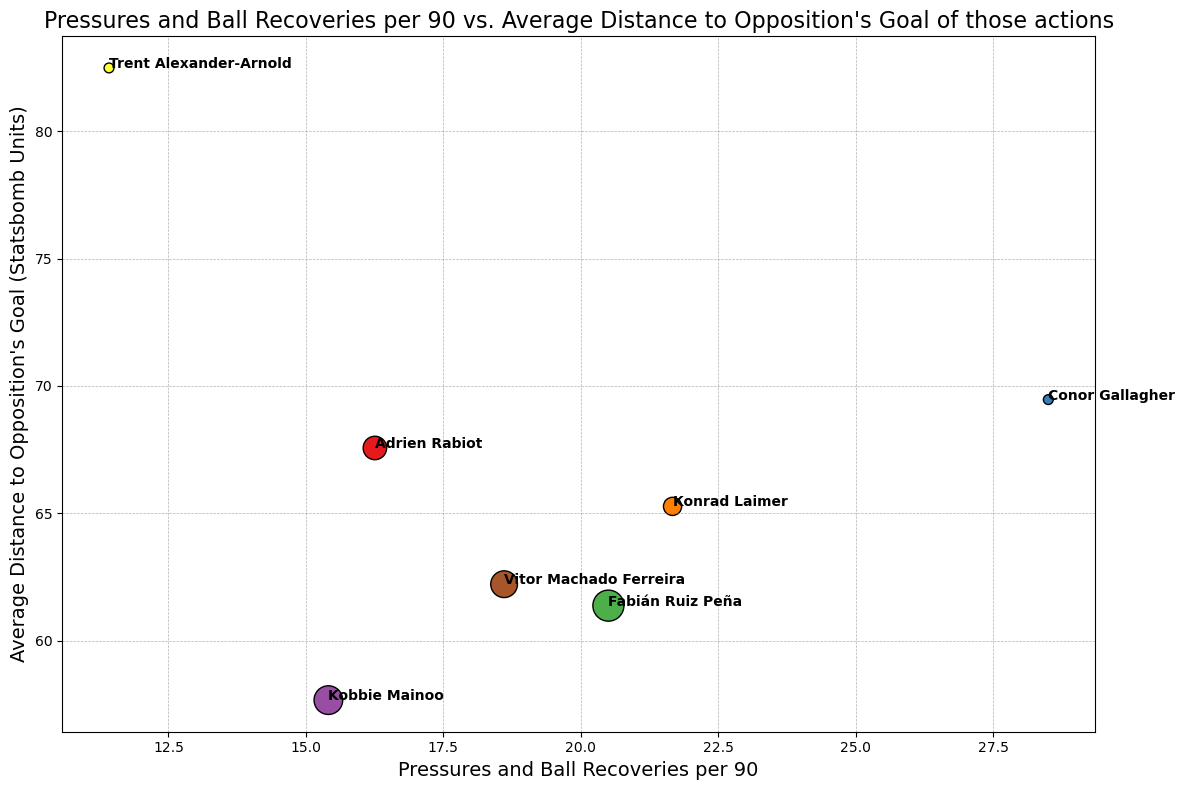

In [76]:
# Plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    data=event_counts_joined, 
    x='pressures_recoveries_per_90', 
    y='average_distance_to_oppositions_goal', 
    hue='player_name', 
    size='proportion_leading_to_shot',  # Use the proportion_leading_to_shot column to size the points
    sizes=(50, 500),  # Define the range of point sizes
    palette='Set1', 
    edgecolor='black',  # Edge color for better contrast
    linewidth=1,
    legend=False  # Remove the legend completely
)

# Add labels
for line in range(event_counts_joined.shape[0]):
    scatter_plot.text(
        event_counts_joined.pressures_recoveries_per_90.iloc[line], 
        event_counts_joined.average_distance_to_oppositions_goal.iloc[line], 
        event_counts_joined.player_name.iloc[line],
        horizontalalignment='left',
        size='medium',  # Regular text size
        color='black',
        weight='bold'# Default black text
    )

# Improve aesthetics
plt.title('Pressures and Ball Recoveries per 90 vs. Average Distance to Opposition\'s Goal of those actions', 
          fontsize=16)
plt.xlabel('Pressures and Ball Recoveries per 90', fontsize=14)
plt.ylabel('Average Distance to Opposition\'s Goal (Statsbomb Units)', fontsize=14)

# Add subtle gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey', alpha=0.6)

plt.tight_layout()  # Adjust layout to fit labels

# Display the plot
plt.show()





## T test: check whether Mainoo was signifficantly different to other players 

In [39]:
# Correct way to filter DataFrame rows based on player names
filtered_df_player = filtered_df[filtered_df['player_name'].isin(['Conor Gallagher', 'Trent Alexander-Arnold', 'Adrien Rabiot', 'Fabián Ruiz Peña', 'Kobbie Mainoo'])]

# Select specific columns to display
filtered_df_player = filtered_df_player[['player_name', 'distance_from_opposition_goal']]

In [40]:
# Define Kobbie Mainoo's data
data_mainoo = filtered_df_player[filtered_df_player['player_name'] == 'Kobbie Mainoo']['distance_from_opposition_goal']

# List of other players to compare with Kobbie Mainoo
other_players = ['Conor Gallagher', 'Fabián Ruiz Peña', 'Adrien Rabiot', 'Trent Alexander-Arnold']

# Store results
results = []

for player in other_players:
    # Extract data for the other player
    data_other = filtered_df_player[filtered_df_player['player_name'] == player]['distance_from_opposition_goal']
    
    # Perform independent samples T-test
    t_statistic, p_value = ttest_ind(data_mainoo, data_other, equal_var=False)  # Welch's T-test
    
    # Store the results
    results.append({
        'player_comparison': f'Kobbie Mainoo vs {player}',
        't_statistic': t_statistic,
        'p_value': p_value
    })

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
print(results_df)

# Apply Bonferroni correction
alpha = 0.05
bonferroni_alpha = alpha / len(other_players)
print(f'Bonferroni corrected alpha: {bonferroni_alpha}')

# Adjust p-values
results_df['adjusted_p_value'] = results_df['p_value'] * len(other_players)
results_df['significant'] = results_df['adjusted_p_value'] < alpha

print(results_df)

                         player_comparison  t_statistic  p_value
0         Kobbie Mainoo vs Conor Gallagher          NaN      NaN
1        Kobbie Mainoo vs Fabián Ruiz Peña     1.546854  0.12923
2           Kobbie Mainoo vs Adrien Rabiot          NaN      NaN
3  Kobbie Mainoo vs Trent Alexander-Arnold          NaN      NaN
Bonferroni corrected alpha: 0.0125
                         player_comparison  t_statistic  p_value  \
0         Kobbie Mainoo vs Conor Gallagher          NaN      NaN   
1        Kobbie Mainoo vs Fabián Ruiz Peña     1.546854  0.12923   
2           Kobbie Mainoo vs Adrien Rabiot          NaN      NaN   
3  Kobbie Mainoo vs Trent Alexander-Arnold          NaN      NaN   

   adjusted_p_value  significant  
0               NaN        False  
1          0.516921        False  
2               NaN        False  
3               NaN        False  


In [41]:
# List of other players to compare with Kobbie Mainoo
other_players = ['Conor Gallagher', 'Fabián Ruiz Peña', 'Adrien Rabiot', 'Trent Alexander-Arnold']

# Define Kobbie Mainoo's data
data_mainoo = filtered_df_player[filtered_df_player['player_name'] == 'Kobbie Mainoo']['distance_from_opposition_goal']

# Store results for individual tests
individual_results = []

for player in other_players:
    # Extract data for the other player
    data_other = filtered_df_player[filtered_df_player['player_name'] == player]['distance_from_opposition_goal']
    
    # Perform independent samples T-test
    t_statistic, p_value = ttest_ind(data_mainoo, data_other, equal_var=False)  # Welch's T-test
    
    # Store the individual result
    individual_results.append({
        'player_comparison': f'Kobbie Mainoo vs {player}',
        't_statistic': t_statistic,
        'p_value': p_value
    })

# Convert individual results to DataFrame for easy viewing
individual_results_df = pd.DataFrame(individual_results)
print(individual_results_df)


                         player_comparison  t_statistic  p_value
0         Kobbie Mainoo vs Conor Gallagher          NaN      NaN
1        Kobbie Mainoo vs Fabián Ruiz Peña     1.546854  0.12923
2           Kobbie Mainoo vs Adrien Rabiot          NaN      NaN
3  Kobbie Mainoo vs Trent Alexander-Arnold          NaN      NaN
